# Выбор локации для скважины

## План работы

Для успешного выполнения проекта необходимо выполнить следующее:
1. Загрузить и изучить данные:
   - проверить данные на наличие пропусков
   - проверить данные на дубликаты
   - оценить, необходимо ли изменять формат данных у каких-либо признаков
2. Разделить их на тренировочную и валидационную выборки
3. Закодировать признаки, в случае, если они представлены не в числовом формате
4. Масштабировать численные признаки 
5. Обучить модель линейной регрессии для каждого региона и сохранить предсказания вместе с целевыми признаками
6. Определить RMSE для каждого региона и средние запасы предсказанного сырья
7. Рассчитать минимально допустимый объем сырья для отсутствия убытков
8. Определить суммарный объем сырья в скважинах с наибольшими значениями предсказания
9. Определить прибыль для данного объема сырья
10. Найти распределение прибыли, среднюю прибыль, 95%-й доверительный интервал и риск отрицательной прибыли
11. Предложить регион для строительства скважин и разработки месторождений

## Загрузка и подготовка данных

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from scipy import stats as st
from numpy.random import RandomState

###  Загрузка данных

Загрузим данные и создадим список с названиями, для дальнейшей работы с ними с помощью функций.

In [2]:
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')

all_geo_data = [geo_data_0, geo_data_1, geo_data_2]

### Предобработка данных

Рассмотрим первые пять строк каждой таблицы и общую информацию о данных 

In [3]:
for data in all_geo_data:
    print('-' * 50)
    print(data.head())
    print('-' * 50)
    data.info()
    print('-' * 50)

--------------------------------------------------
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------
--------------------------------------------------
      id         f0         f1        f2     product
0  

Как мы видим, в данных отсутствуют какие-либо пропуски, а типы данных используются оптимально.

### Поиск дубликатов 

Проанализируем данные с точки зрения наличия дубликатов, как явных, так и по уникальному идентификатору скважины.

In [4]:
for data in all_geo_data:
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    print(f'Количество дубликатов в столбце "id": {data["id"].duplicated().sum()}')

Количество явных дубликатов: 0
Количество дубликатов в столбце "id": 10
Количество явных дубликатов: 0
Количество дубликатов в столбце "id": 4
Количество явных дубликатов: 0
Количество дубликатов в столбце "id": 4


Явные дубликаты в данных так же отсутствуют, но в столбце `id` присутствуют повторные уникальные идентификаторы.
Рассмотрим их.

In [5]:
for data in all_geo_data:
    print(data[data['id'].duplicated(keep=False)].sort_values(by='id'))

          id        f0        f1         f2     product
66136  74z30  1.084962 -0.312358   6.990771  127.643327
64022  74z30  0.741456  0.459229   5.153109  140.771492
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
931    HZww2  0.755284  0.368511   1.863211   30.681774
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
41724  bxg6G -0.823752  0.546319   3.630479   93

Как мы видим, скважины с одинаковыми идентификаторами имеют аблосютно разные остальные характеристики.
Замена их на какое-либо среднее не представляется логичным. Скорее, можно предположить об ошибке в присвоении идентификатора скважине; а поскольку данный столбец не будет использоваться в обучении модели, как не релевантный, то можно проигнорировать данные дубликаты.

### Разбиение на выборки

Разделим данные на целевой признак и признаки, которые будут использоваться при обучении и предсказании.

Целевым признаком является `product` - значение объёма запасов в скважине (тыс. баррелей).
Из остальных признаков уберем столбец с идентификатором, поскольку это случайный набор символов.

In [6]:
target_0 = geo_data_0['product']
features_0 = geo_data_0.drop(['product', 'id'], axis=1)

target_1 = geo_data_1['product']
features_1 = geo_data_1.drop(['product', 'id'], axis=1)

target_2 = geo_data_2['product']
features_2 = geo_data_2.drop(['product', 'id'], axis=1)

Все данные разобъем на выборки в соотношении 3:1 - 75% для тренировочной и 25% для валидационной.
Кроме того, сразу зададим `random_state`, чтобы в дальнейшем использовать уже записанную переменную.

In [7]:
random_state = 12345

features_train_0,features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=random_state
)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=random_state
)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=random_state
)

Проверим размеры выборок

In [8]:
print('Размер тренировочной выборки № 1:', len(features_train_0))
print('Размер валидационной выборки № 1:', len(features_valid_0))

print('Размер тренировочной выборки № 2:', len(features_train_1))
print('Размер валидационной выборки № 2:', len(features_valid_1))

print('Размер тренировочной выборки № 3:', len(features_train_2))
print('Размер валидационной выборки № 3:', len(features_valid_2))

Размер тренировочной выборки № 1: 75000
Размер валидационной выборки № 1: 25000
Размер тренировочной выборки № 2: 75000
Размер валидационной выборки № 2: 25000
Размер тренировочной выборки № 3: 75000
Размер валидационной выборки № 3: 25000


Данные разбиты верно.

### Масштабирование признаков. 

Обучим `scaler` на тренировочных выборках, а затем смасштабируем все признаки.

In [9]:
def scale_features(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train)
    
    scaled_features_train = scaler.transform(features_train)
    scaled_features_valid = scaler.transform(features_valid)
    
    return scaled_features_train, scaled_features_valid

features_train_0, features_valid_0 = scale_features(features_train_0, features_valid_0)
features_train_1, features_valid_1 = scale_features(features_train_1, features_valid_1)
features_train_2, features_valid_2 = scale_features(features_train_2, features_valid_2)

## Обучение и проверка модели

В данном проекте будет использоваться модель линейной регрессии. Обучим модель на тренировочных данных для каждого региона и сохраним предсказания вместе с реальными значениями целевого признака в отдельной переменной.

In [10]:
def get_predicts(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index)
    
    print(f'Средний запас сырья (предсказанный): {predictions.mean()}')
    print(f'RMSE модели: {mean_squared_error(target_valid, predictions, squared=False)}')
    
    result = pd.concat([target_valid, predictions], axis=1)
    result.columns = ['product_valid', 'product_predicted']
    
    return result

In [11]:
prediction_0 = get_predicts(features_train_0, target_train_0, features_valid_0, target_valid_0)

Средний запас сырья (предсказанный): 92.59256778438035
RMSE модели: 37.5794217150813


In [12]:
prediction_1 = get_predicts(features_train_1, target_train_1, features_valid_1, target_valid_1)

Средний запас сырья (предсказанный): 68.728546895446
RMSE модели: 0.893099286775617


In [13]:
prediction_2 = get_predicts(features_train_2, target_train_2, features_valid_2, target_valid_2)

Средний запас сырья (предсказанный): 94.96504596800489
RMSE модели: 40.02970873393434


### Вывод 

Как мы видим, лучшие результаты дала модель, обученная на данных по второму региону - значение RMSE в этом случае не превышает 0.9, при этом значение предсказанного среднего запаса сырья ниже, чем в других регионах.
В остальных регионах средний предсказанный объем сырья достигает 92-94 тыс. баррелей, но значение RMSE моделей выше - 37.5-40.

## Подготовка к расчёту прибыли

Для упрощения расчетов, добавим все необходимые значения в переменные:
- Бюджет на разработку месторождения - 10 млрд рублей
- Доход от 1 тыс. баррелей - 450 000 рублей
- Количество скважин для исследования - 500
- Количество скважин для разработки - 200

In [14]:
EXPLORATION_BUDGET = 10_000_000_000
PRODUCT_INCOME = 450_000
EXPLORATION_WELL_COUNT = 500
DEVELOPMENT_WELL_COUNT = 200

Рассчитаем достаточный объем для безубыточности производства. Для этого, разделим бюджет на разработку месторождения на доход от 1 тыс. баррелей.

In [15]:
breakeven_volume = EXPLORATION_BUDGET / PRODUCT_INCOME
breakeven_volume_per_well = breakeven_volume / DEVELOPMENT_WELL_COUNT
print(f'Достаточный объем для безубыточности добычи: {"%.2f" %breakeven_volume}')
print(f'Достаточный объем на одной скважине для безубыточности добычи: {"%.2f" %breakeven_volume_per_well}')

Достаточный объем для безубыточности добычи: 22222.22
Достаточный объем на одной скважине для безубыточности добычи: 111.11


Для безубыточности производства, необходимо, чтобы на каждой из 200 скважин можно было добыть не меньше 111 тыс. баррелей нефти.

Рассмотрим средний объем нефти на скважинах в каждом регионе.

In [16]:
n = 1
for data in all_geo_data:
    print(f'Средний объем нефти на скважине в регионе № {n}: {"%.2f" %(data["product"].mean())}')
    n += 1

Средний объем нефти на скважине в регионе № 1: 92.50
Средний объем нефти на скважине в регионе № 2: 68.83
Средний объем нефти на скважине в регионе № 3: 95.00


Как видно из полученных данных, в среднем количество нефти, которую можно добыть из одной скважины, в каждом регионе ниже, чем необходимое значение для безубыточности производства.
В связи с этим, необходимо взять только лучшие скважины для получения дохода.

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли из 200 лучших скважин для дальнейшего расчета прибыли.

In [17]:
def region_income(prediction):
    target_wells = prediction.sort_values(by='product_predicted', ascending=False).iloc[:DEVELOPMENT_WELL_COUNT]
    total_product = target_wells['product_valid'].sum()
    region_income = total_product * PRODUCT_INCOME  - EXPLORATION_BUDGET
    return region_income

Определим прибыль и риски для каждого региона. В ходе расчетов применим технологию `Bootstrap`.

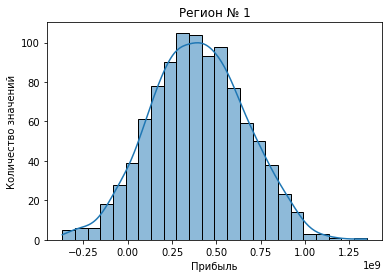

Средняя прибыль: 396164984.80 
Доверительный 95% интервал: -111215545.89 - 909766941.55 
Риск отрицательной выручки: 6.90


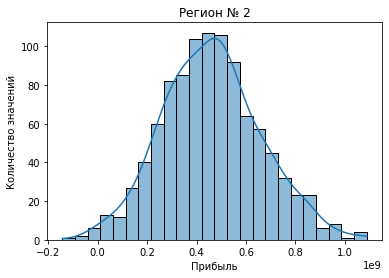

Средняя прибыль: 461155817.28 
Доверительный 95% интервал: 78050810.75 - 862952060.26 
Риск отрицательной выручки: 0.70


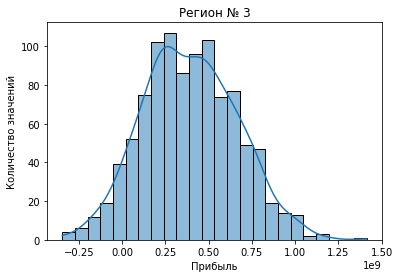

Средняя прибыль: 392950475.17 
Доверительный 95% интервал: -112227625.38 - 934562914.55 
Риск отрицательной выручки: 6.50


In [18]:
predictions = [prediction_0, prediction_1, prediction_2]
state = RandomState(random_state)
region = 1
for prediction in predictions:
    region_name = f'Регион № {region}'
    bootstrap_samples = 1000
    
    incomes = []
    
    for i in range(bootstrap_samples):
        sample = prediction.sample(
            n=EXPLORATION_WELL_COUNT, replace=True, random_state=state
        )
        
        income = region_income(sample)
        incomes.append(income)
        
    ax = sns.histplot(data=incomes, kde=True)
    ax.set(xlabel='Прибыль', ylabel='Количество значений', title=region_name)
    plt.show()
    incomes = pd.Series(incomes)
    mean_income = incomes.mean()
    lower_bound = incomes.quantile(q=0.025)
    upper_bound = incomes.quantile(q=0.975)
    risk = (incomes < 0).mean() * 100
    print(
        f'Средняя прибыль: {"%.2f" %(mean_income)} \nДоверительный 95% интервал: {"%.2f" %(lower_bound)} - {"%.2f" %(upper_bound)} \nРиск отрицательной выручки: {"%.2f" %(risk)}')
    region += 1

По итогам проведенного анализа, можно сделать вывод, что **регион № 2 лучше всего подходит для разработки**:
- для данного региона обученная модель дала результат с наименьшим значением RMSE
- для данного региона средняя прибыль является наибольшей из трех регионов и составляет 461 155 817.28 рублей
- доверительный интервал для данного региона единственный имеет положительную нижнюю границу (78 050 810.75 - 862 952 060.26)
- риск отрицательной выручки наименьший среди всех регионов и составляет 0.9%